In [11]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import swiper.plot as plotter
from typing import Any

In [12]:
# directory = 'slurm/data/20241108_155445'
directory = 'slurm/data/20241111_145046'

In [13]:
with open(f'{directory}/config.json', 'r') as f:
    config = json.load(f)

In [14]:
data_by_config = {}

for file in os.listdir(f'{directory}/output/'):
    print(file)
    with open(f'{directory}/output/{file}', 'r') as f:
        contents = f.read()
        if len(contents) == 0:
            print('Empty file!')
            continue
        data = json.loads(contents)
    config_idx = int(file.split('_')[0][6:])
    data_by_config[config_idx] = data

config177_d21_aligned_separate_random_t_1000_200_0_0.json
config92_d21_sliding_separate_random_t_1000_200_0_0.json
config228_d21_parallel_separate_random_t_1000_200_0_0.json
config162_d21_parallel_separate_random_t_1000_200_0_0.json
config152_d21_sliding_separate_random_t_1000_200_0_0.json
config5_d21_sliding_separate_random_t_1000_200_0_0.json
config237_d21_aligned_separate_random_t_1000_200_0_0.json
config38_d21_sliding_separate_random_t_1000_200_0_0.json
config252_d21_parallel_separate_random_t_1000_200_0_0.json
config60_d21_sliding_separate_random_t_1000_200_0_0.json
config13_d21_parallel_separate_random_t_1000_200_0_0.json
config212_d21_sliding_separate_random_t_1000_200_0_0.json
config156_d21_sliding_separate_random_t_1000_200_0_0.json
config1_d21_sliding_separate_random_t_1000_200_0_0.json
config173_d21_aligned_separate_random_t_1000_200_0_0.json
config299_d21_aligned_separate_random_t_1000_200_0_0.json
config96_d21_sliding_separate_random_t_1000_200_0_0.json
config64_d21_slidin

In [15]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            return idx
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

In [16]:
get_data(config, data_by_config, 'random_t_1000_200_0', {})['device_data'].keys()

dict_keys(['d', 'num_rounds', 'completed_instructions', 'instructions', 'instruction_start_times', 'all_patch_coords', 'syndrome_count_by_round', 'instruction_count_by_round', 'generated_syndrome_data', 'patches_initialized_by_round', 'conditioned_decode_wait_times', 'avg_conditioned_decode_wait_time'])

In [52]:
ordered_configs = [
    ('parallel', True),
    ('aligned', True),
    ('sliding', True),
]

"""
all_data[method][spec_acc][decode_latency] = data
"""

broken_configs = []
all_data = {conf:{} for conf in ordered_configs}
for (scheduling_method,spec_on) in ordered_configs:
    made_label = False
    for config_idx,data in data_by_config.items():
        spec = config[config_idx]['speculation_mode'] != None
        sched = config[config_idx]['scheduling_method']
        if sched != scheduling_method or spec != spec_on:
            continue
        decoding_latency = float(config[config_idx]['decoder_latency_or_dist_filename'].split('*')[-1])
        speculation_accuracy = config[config_idx]['speculation_accuracy']
        success = data['success']
        if success:
            vals = data['device_data']['conditioned_decode_wait_times']
            assert len(vals) == 1000
            if np.mean([vals[k] for k in list(sorted(vals.keys()))[-10:]]) > 1.5 * np.mean([vals[k] for k in list(sorted(vals.keys()))[10:20]]):
                success = False
        if data['success']:
            # use avg
            all_data[(scheduling_method,spec_on)].setdefault(speculation_accuracy, {})[decoding_latency] = data['device_data']['avg_conditioned_decode_wait_time']
        else:
            # use last
            # all_data[(scheduling_method,spec_on)].setdefault(speculation_accuracy, {})[decoding_latency] = data['device_data']['conditioned_decode_wait_times']
            all_data[(scheduling_method,spec_on)].setdefault(speculation_accuracy, {})[decoding_latency] = 10**6
            broken_configs.append((scheduling_method,spec_on,speculation_accuracy,decoding_latency))
            print(f"Failed: {scheduling_method}, {spec_on}, {speculation_accuracy}, {decoding_latency}")
        # TODO: should mark any whose values continually increase over
        # experiment duration as "not scalable" (use hatches to mark on graph,
        # or color gray)

Failed: sliding, True, 0.0, 1.291549665014884
Failed: sliding, True, 0.1, 5.994842503189409
Failed: sliding, True, 0.30000000000000004, 2.1544346900318834
Failed: sliding, True, 0.2, 0.774263682681127
Failed: sliding, True, 0.2, 1.291549665014884
Failed: sliding, True, 0.30000000000000004, 3.593813663804626
Failed: sliding, True, 0.1, 10.0
Failed: sliding, True, 0.0, 0.774263682681127
Failed: sliding, True, 0.4, 5.994842503189409
Failed: sliding, True, 0.2, 2.1544346900318834
Failed: sliding, True, 0.0, 3.593813663804626
Failed: sliding, True, 0.4, 10.0
Failed: sliding, True, 0.0, 2.1544346900318834
Failed: sliding, True, 0.2, 3.593813663804626
Failed: sliding, True, 0.0, 5.994842503189409
Failed: sliding, True, 0.1, 1.291549665014884
Failed: sliding, True, 0.2, 10.0
Failed: sliding, True, 0.2, 5.994842503189409
Failed: sliding, True, 0.1, 0.774263682681127
Failed: sliding, True, 0.0, 10.0
Failed: sliding, True, 0.5, 10.0
Failed: sliding, True, 0.30000000000000004, 10.0
Failed: sliding

In [53]:
all_data[('sliding', True)][1.0]

{10.0: 441.0,
 5.994842503189409: 273.0,
 0.2782559402207124: 33.0,
 2.1544346900318834: 112.0,
 3.593813663804626: 172.0,
 0.46415888336127786: 41.0,
 0.774263682681127: 54.0,
 0.1: 26.0,
 0.16681005372000587: 29.0,
 1.291549665014884: 76.0}

In [54]:
all_data[('aligned', True)][1.0]

{5.994842503189409: 345.975,
 10.0: 566.613,
 3.593813663804626: 214.492,
 0.46415888336127786: 45.575,
 0.2782559402207124: 36.073,
 2.1544346900318834: 135.559,
 0.16681005372000587: 30.479,
 1.291549665014884: 88.994,
 0.774263682681127: 61.993,
 0.1: 26.766}

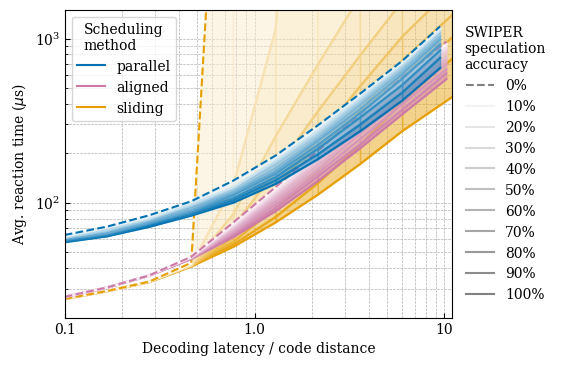

In [144]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
colors = ['C0', 'C1', 'C3']
def interpolate_white(color, alpha):
    return LinearSegmentedColormap.from_list('_', ['white', color])(alpha)
zorders = [2,1.9,1.8]
x_offsets = [-0.5, 0.25, 1.0]
plot_lines = []
legend_lines = []
for i,(scheduling_method,spec_on) in enumerate(ordered_configs):
    data = all_data[(scheduling_method,spec_on)]
    for j,spec_acc in enumerate(sorted(data.keys())):
        keys = sorted(data[spec_acc].keys())
        xvals = keys.copy()
        xvals[-1] += x_offsets[i]
        if spec_acc == 0:
            alpha = 1
            linestyle = '--'
        else:
            alpha = spec_acc
            linestyle = '-'
        if j+1 < len(data):
            vals_next = data[sorted(data.keys())[j+1]]
            for k,dec_lat in enumerate(sorted(data[spec_acc].keys())):
                if k != len(data[spec_acc])-1:
                    dec_lat_next = sorted(data[spec_acc].keys())[k+1]
                    # if (scheduling_method, spec_on, spec_acc, dec_lat_next) in broken_configs:
                    #     color = 'gray'
                    # else:
                    color = interpolate_white(colors[i], alpha)
                    ax.fill_between([xvals[k], xvals[k+1]], [data[spec_acc][dec_lat], data[spec_acc][dec_lat_next]], [vals_next[dec_lat], vals_next[dec_lat_next]], color=color, zorder=zorders[i]+0.001*(len(data)-j), alpha=0.5)
        # alpha = (alpha+1)/2 if spec_acc > 0 else alpha
        lines, = ax.plot(xvals, [data[spec_acc][k] for k in sorted(data[spec_acc].keys())], label=(f'{scheduling_method}' if spec_acc == 1 else None), color=interpolate_white(colors[i], alpha) if spec_acc > 0 else colors[i], linestyle=linestyle, zorder=(zorders[i]+0.01+0.001*(len(data)-j)))
        if spec_acc == 1:
            plot_lines.append(lines)
        if i == 0:
            lines, = ax.plot([-2, -1], [0, 0], label=(f'{spec_acc*100:.0f}%' if spec_acc > 0 else '0%'), color=interpolate_white('gray', alpha) if spec_acc > 0 else 'gray', linestyle=linestyle)
            legend_lines.append(lines)
leg1 = ax.legend(plot_lines, [method for method,_ in ordered_configs], title='Scheduling\nmethod')
leg2 = ax.legend(legend_lines, [f'{spec_acc*100:.0f}%' for spec_acc in sorted(data.keys())], title='SWIPER\nspeculation\naccuracy', bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
ax.add_artist(leg1)
plt.xscale('log')
plt.yscale('log')
# plt.xticks(sorted(all_data[('parallel', True)][1.0].keys()),
# sorted(all_data[('parallel', True)][1.0].keys()))
plt.xticks([0.1, 1.0, 10], ['0.1', '1.0', '10'])
plt.tick_params(axis='x', which='minor', bottom=False)
plt.xlabel('Decoding latency / code distance')
plt.ylabel(r'Avg. reaction time ($\mu$s)')
plt.ylim(2e1, 1.5e3)
plt.xlim(0.1, 11)
# cmap = mpl.colormaps['Greys']
# cmap = LinearSegmentedColormap.from_list('_', ['white', 'gray'])
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.BoundaryNorm(np.linspace(0, 1, 11), cmap.N)), ax=ax, label='Speculation accuracy')
# cbar.ax.invert_yaxis()
plt.tick_params(direction='in', which='both')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('notebooks/figures/sensitivity_study.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/sensitivity_study.svg', bbox_inches='tight')

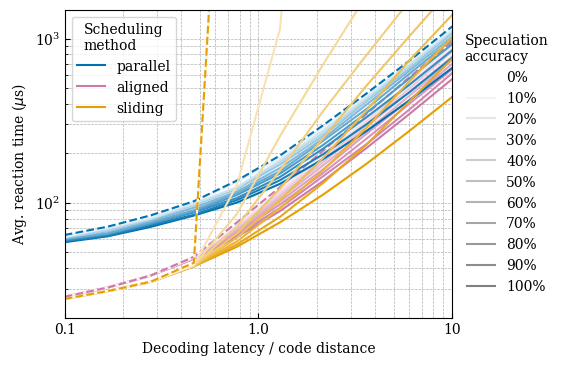

In [125]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
colors = ['C0', 'C1', 'C3']
def interpolate_white(color, alpha):
    return LinearSegmentedColormap.from_list('_', ['white', color])(alpha)
zorders = [1.9, 1.8, 2]
plot_lines = []
legend_lines = []
for i,(scheduling_method,spec_on) in enumerate(ordered_configs):
    data = all_data[(scheduling_method,spec_on)]
    for j,spec_acc in enumerate(sorted(data.keys())):
        if spec_acc == 0:
            alpha = 1
            linestyle = '--'
        else:
            alpha = spec_acc
            linestyle = '-'
        lines, = ax.plot(sorted(data[spec_acc].keys()), [data[spec_acc][k] for k in sorted(data[spec_acc].keys())], label=(f'{scheduling_method}' if spec_acc == 1 else None), color=interpolate_white(colors[i], alpha) if spec_acc > 0 else colors[i], linestyle=linestyle, zorder=(zorders[i]+0.01+0.001*(len(data)-j)))
        if spec_acc == 1:
            plot_lines.append(lines)
        if i == 0:
            lines, = ax.plot([-2, -1], [0, 0], label=(f'{spec_acc*100:.0f}%' if spec_acc > 0 else '0%'), color=interpolate_white('gray', alpha), linestyle=linestyle)
            legend_lines.append(lines)
leg1 = ax.legend(plot_lines, [method for method,_ in ordered_configs], title='Scheduling\nmethod')
leg2 = ax.legend(legend_lines, [f'{spec_acc*100:.0f}%' for spec_acc in sorted(data.keys())], title='Speculation\naccuracy', bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
ax.add_artist(leg1)
plt.xscale('log')
plt.yscale('log')
# plt.xticks(sorted(all_data[('parallel', True)][1.0].keys()),
# sorted(all_data[('parallel', True)][1.0].keys()))
plt.xticks([0.1, 1.0, 10], ['0.1', '1.0', '10'])
plt.tick_params(axis='x', which='minor', bottom=False)
plt.xlabel('Decoding latency / code distance')
plt.ylabel(r'Avg. reaction time ($\mu$s)')
plt.ylim(2e1, 1.5e3)
plt.xlim(0.1, 10)

plt.tick_params(direction='in', which='both')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('notebooks/figures/sensitivity_study.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/sensitivity_study.svg', bbox_inches='tight')